<h1><center><font size="9">EDA</font></center></h1>

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from folium import plugins
import numpy as np

In [4]:
df = pd.read_csv('../data/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
# get copy of df
df_copy = df.copy()

# assemble all the rows from name
all_name = df_copy['name'].str.cat(sep=',')

# transform all_name into tokenized_word
text = all_name
tokenized_word = word_tokenize(text)

# generate a set of all non-important words
stop_words = set(stopwords.words("english"))

# delete all non-important words
filtered_sent = []
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent.append(w)

# reduce words to word root
ps=PorterStemmer()
stemmed_words=[]
for w in filtered_sent:
    stemmed_words.append(ps.stem(w))
    
# get top 10 most common words
fdist = FreqDist(stemmed_words)
topmostcommonwords = fdist.most_common(10)
df_commonwords = pd.DataFrame(topmostcommonwords, columns=['word','count'])
df_commonwords

,word,count
0,",",55567
1,room,10096
2,!,7855
3,bedroom,7787
4,privat,7166
5,apart,6480
6,cozi,5021
7,apt,4323
8,brooklyn,4010
9,studio,3943


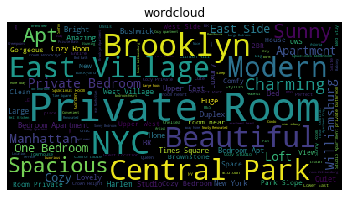

In [6]:
text = all_name
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('wordcloud')
plt.savefig('../figures/wordcloud.png',dpi=100)
plt.show()

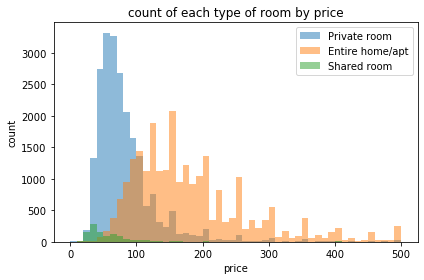

In [6]:
categories = df['room_type'].unique()
# I choose the boundary of price to be between 0 and 500
bin_range = (0,500)

for c in categories:
    plt.hist(df[df['room_type']==c]['price'],alpha=0.5,label=c,range=bin_range,bins=50)
plt.legend()
plt.ylabel('count')
plt.xlabel('price')
plt.title('count of each type of room by price')
plt.tight_layout()
plt.savefig('../figures/histogram.png',dpi=100)
plt.show()

In [7]:
df_copy = pd.read_csv('../data/AB_NYC_2019.csv')
df_top200_reviews_per_month=df_copy.sort_values(by=['reviews_per_month'],ascending=False).head(200)
#print("The average of longitude:",(df['longitude'].max()+df['longitude'].min())/2)
#print("The average of latitude:",(df['latitude'].max()+df['latitude'].min())/2)
df_avg_longitude = (df['longitude'].max()+df['longitude'].min())/2
df_avg_latitude = (df['latitude'].max()+df['latitude'].min())/2
def generateBaseMap(default_location=[df_avg_latitude,df_avg_longitude], default_zoom_start=12):
    heatmap = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return heatmap
heatmap=generateBaseMap()

df_top200_reviews_per_month_map=plugins.MarkerCluster().add_to(heatmap)

for latitude_var,longitude_var,name in zip(df_top200_reviews_per_month['latitude'],df_top200_reviews_per_month['longitude'],
                                          df_top200_reviews_per_month['name']):
    folium.Marker(location=[latitude_var,longitude_var],icon=folium.Icon(icon='home'), popup=name).add_to(df_top200_reviews_per_month_map)
heatmap.add_child(df_top200_reviews_per_month_map)
heatmap

In [8]:
df_preprocessed = pd.read_csv('../data/preprocessed_data.csv')
#df_preprocessed.head()

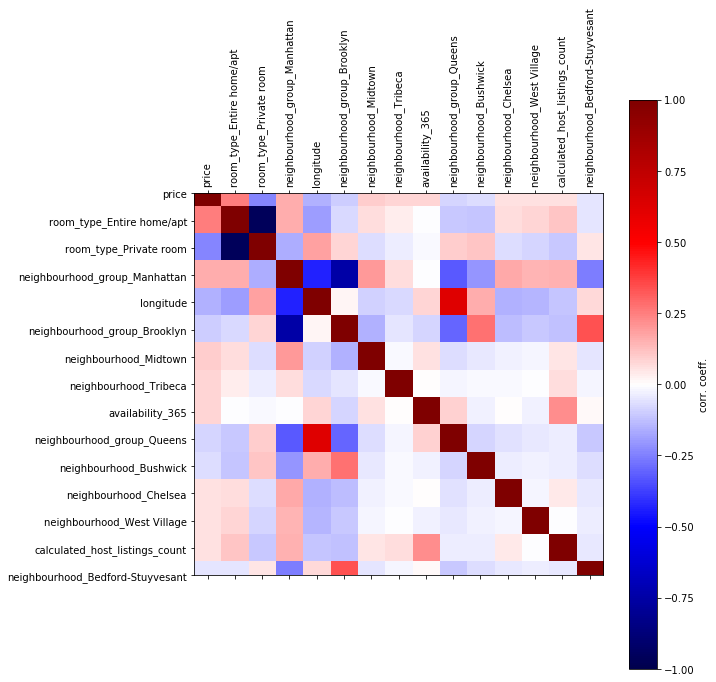

In [9]:
corrmat = df_preprocessed.corr()
# use the absolute value of the correlation matrix for sorting!
all_cols = np.abs(corrmat).sort_values('price',ascending=False)['price'].index 
cols = all_cols[:15] # positively correlated features

cm = corrmat.loc[cols,cols]

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,10))
plt.matshow(cm,vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(cm.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm.shape[0]),list(cols))
plt.tight_layout()
plt.savefig('../figures/corr_matrix.png',dpi=300)
plt.show()